# Agents:
These simulations evaluate several agents exploring the thread the needle enviroment

In [2]:
%load_ext autoreload
%autoreload 2
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
%matplotlib inline
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from state_inference.gridworld_env import CnnWrapper, ThreadTheNeedleEnv
from state_inference.utils.training_utils import parse_task_config, parse_model_config
from state_inference.utils.pytorch_utils import DEVICE
from state_inference.model.agents import ViAgentWithExploration, RecurrentViAgent
from state_inference.model.vae import CnnVae

print(f"python {sys.version}")
print(f"torch {torch.__version__}")
print(f"device = {DEVICE}")


python 3.10.11 (main, Apr 20 2023, 13:58:42) [Clang 14.0.6 ]
torch 2.0.1
device = mps


In [4]:
TASK_CONFIG_FILE = "state_inference/env_config.yml"
TASK_NAME = "thread_the_needle"
TASK_CLASS = ThreadTheNeedleEnv

MODEL_CONFIG_FILE = "state_inference/model/model_config.yml"

In [5]:
env_kwargs, training_kwargs = parse_task_config(TASK_NAME, TASK_CONFIG_FILE)

training_kwargs["n_train_steps"] = 50000
training_kwargs["n_epochs"] = 1

# create the task
task = CnnWrapper(TASK_CLASS.create_env(**env_kwargs))

pi, _ = task.get_optimal_policy()
training_kwargs["optimal_policy"] = pi

  0%|          | 0/1000 [00:00<?, ?it/s]

In [6]:
### Model + Training Parameters

model_config = parse_model_config(MODEL_CONFIG_FILE)


def make_model():
    vae_model = CnnVae.make_from_configs(model_config, env_kwargs)

    agent = ViAgentWithExploration(
        task,
        vae_model,
        set_action=set(range(4)),
        **model_config["state_inference_model"],
    )
    return agent


In [7]:
# get a dataset from exploration without regard to model
rnn_agent = make_model()
rnn_agent.learn(10000, progress_bar=True, estimate_batch=False)

Steps: 100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [01:08<00:00, 146.44it/s]


In [11]:
# get a dataloader for testing
dataloader = RecurrentViAgent.construct_dataloader_from_obs(64, rnn_agent.cached_obs, 8)
batch_data = next(iter(dataloader))

In [12]:
batch_data[1]

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 1., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 1., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.]],

        ...,

        [[0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         ...,
         [0., 0., 1., 0.],
         [0., 0., 0., 1.],
         [0., 0., 1., 0.]],

        [[1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         ...,
         [0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]],

        [[1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         ...,
 

In [22]:
from state_inference.utils.pytorch_utils import train_epochs

# def make_rnn():
    

# test_loader = RecurrentViAgent.contruct_validation_dataloader(1000, 5)

# vae_model = rnn_agent.state_inference_model

# # basic test
# batch_data = next(iter(test_loader))
# with torch.no_grad():
#     print(f"Loss: {vae_model.loss(batch_data).item()}")

# train_args = {
#     "epochs": 20,
#     "lr_decay": None,
#     "lr": 1e-4,
#     "grad_clip": True,
# }


# train_losses, test_losses = train_epochs(
#     rnn_agent.state_inference_model, train_loader, test_loader, train_args
# )
batch_data = next(iter(train_loader))

In [25]:
batch_data[0][0].shape

torch.Size([64, 9, 64, 64, 1])

In [ ]:
# plot state reconstructions

# use the vae to encode all of the test data
vae_model.eval()

batch_data = next(iter(test_loader))
(obs, actions), _ = batch_data
with torch.no_grad():
    _, x_hat = vae_model(obs.to(DEVICE))

# select 5 random examples
N = 5
s = np.random.permutation(np.arange(x_hat.shape[0]))[:N]
print(s)
fig, axes = plt.subplots(N, 2, figsize=(6, 16))
for ii in range(N):
    s = np.random.randint(x_hat.shape[0])
    axes[ii][0].imshow(convert_float_to_8bit(obs[s, -1, ...]).squeeze().numpy())
    axes[ii][1].imshow(
        convert_float_to_8bit(x_hat[s, ...].squeeze().detach().cpu()).numpy()
    )
    axes[ii][0].set_title(f"State {s}")
    axes[ii][1].set_title(f"State {s}, reconstructed")

# s = np.random.randint(0, EMBEDDING_DIM)
# ii = 0
# fig, axes = plt.subplots(5, 2, figsize=(6, 16))
# for s in range(5):
#     _, X_hat = vae_model(test_obs[s, :][None, ...].to(DEVICE))

#     axes[ii][0].imshow(convert_float_to_8bit(test_obs[s, :]))
#     axes[ii][1].imshow(convert_float_to_8bit(X_hat.squeeze().detach().cpu()).numpy())
#     axes[ii][0].set_title(f"State {ii}")
#     axes[ii][1].set_title(f"State {ii}, reconstructed")

#     ii += 1

In [72]:
obs.shape

torch.Size([992, 5, 40, 40, 1])

In [73]:
# use the vae to encode all of the test data
vae_model.eval()

batch_data = next(iter(test_loader))
(obs, actions), _ = batch_data

In [74]:
obs.shape

torch.Size([992, 5, 40, 40, 1])

In [75]:
obs[::-1]

ValueError: step must be greater than zero

In [76]:
(obs, actions), _ = batch_data
with torch.no_grad():
    (logits, z), x_hat = rnn_agent.state_inference_model(
        obs.to(DEVICE), actions.to(DEVICE)
    )
z.shape

TypeError: RecurrentVae.forward() takes 2 positional arguments but 3 were given

In [29]:
x_hat

tensor([[[[0.0888],
          [0.1571],
          [0.1484],
          ...,
          [0.1728],
          [0.0985],
          [0.1931]],

         [[0.1121],
          [0.1454],
          [0.1596],
          ...,
          [0.1537],
          [0.1312],
          [0.1185]],

         [[0.1602],
          [0.1027],
          [0.1636],
          ...,
          [0.1696],
          [0.0559],
          [0.1254]],

         ...,

         [[0.1037],
          [0.1448],
          [0.1128],
          ...,
          [0.2015],
          [0.1183],
          [0.1181]],

         [[0.1271],
          [0.1046],
          [0.1058],
          ...,
          [0.1254],
          [0.1554],
          [0.1014]],

         [[0.0984],
          [0.1070],
          [0.1088],
          ...,
          [0.2027],
          [0.1057],
          [0.0913]]],


        [[[0.1949],
          [0.1557],
          [0.1496],
          ...,
          [0.0947],
          [0.1638],
          [0.1471]],

         [[0.0953],
    

In [66]:
(obs, actions), _ = batch_data

with torch.no_grad():
    loss = rnn_agent.state_inference_model.loss(batch_data)
print(loss.cpu().detach().item())

5.401886940002441


In [40]:
from state_inference.utils.pytorch_utils import convert_8bit_to_float

obs = torch.stack(
    [
        torch.tensor(agent.get_env().env_method("generate_observation", s)[0]).view(
            (40, 40, 1)
        )
        for s in range(400)
    ]
)
obs_float = convert_8bit_to_float(obs)
obs_float[0][None, ...].shape

torch.Size([1, 40, 40, 1])

In [47]:
encoder = rnn_agent.state_inference_model.encoder
rnn_agent.state_inference_model.get_state(obs_float).shape

(400, 5)

In [48]:
agent.state_inference_model.get_state(obs_float)

array([[164,  50, 177, 152, 119],
       [164,  39, 177, 152, 119],
       [164,  39,   8, 152, 119],
       ...,
       [164,  50,   8, 152, 100],
       [164,  50, 177, 152, 119],
       [164,  50, 177, 152, 119]])

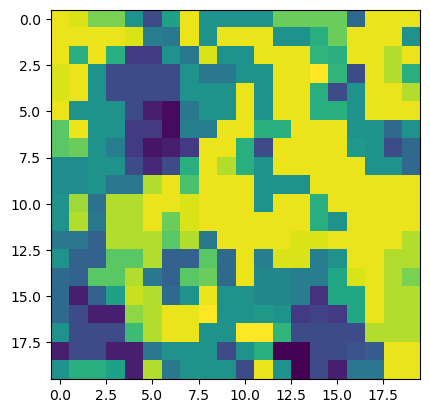

In [60]:
hashed_states = agent._get_hashed_state(obs)
clusters = {z: k for k, z in enumerate(sorted(set(hashed_states)))}
state_clusters = np.array([clusters[z] for z in hashed_states]).reshape(20, 20)
plt.imshow(state_clusters)

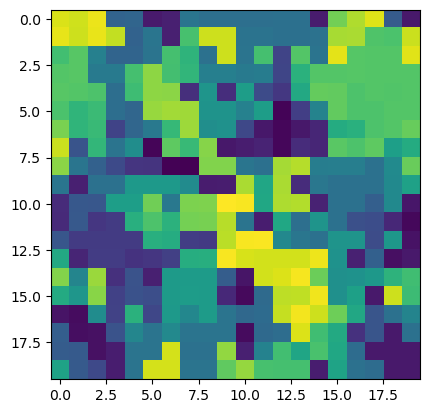

In [59]:
hashed_states = rnn_agent._get_hashed_state(obs, None)
clusters = {z: k for k, z in enumerate(sorted(set(hashed_states)))}
state_clusters = np.array([clusters[z] for z in hashed_states]).reshape(20, 20)
plt.imshow(state_clusters)

In [88]:
h = rnn_agent._init_state()
rnn_agent.predict(obs[0], h)

(tensor([2]), tensor([[180,  34, 188, 138, 195]]))

In [74]:
obs[0].view(-1).shape[0]

1600